In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
###


In [2]:
class AdaptiveThreshold:
    #init是constructor
    def __init__(self, blockSize, C):
        #1個blockSize*blockSize＊1的KERNEL
        self.filters = tf.ones((blockSize, blockSize, 1, 1), dtype=tf.float32) / blockSize ** 2
        self.C = tf.constant(C, dtype=tf.float32)

    def __call__(self, inputs):
        # hint: tf.nn.conv2d, tf.where
        mean = tf.nn.conv2d(inputs, self.filters, strides=[1, 1], padding='SAME')
        x = tf.where(inputs > (mean - self.C), 1.0, 0.0)

        return x  # return the resultant image, where 1 represents above the threshold and 0 represents below the threshold


In [3]:

class Thinning:

    def __init__(self):
        self.filters1, self.filters2 = self._surface_patterns()

    #檢查rule 1的最後一個規則
    @staticmethod
    def _rule1_final_check(array):
        n_135_is_zero = False
        n_357_is_zero = False
        if array[1] == 0 or array[3] == 0 or array[5] == 0:
            n_135_is_zero = True
        if array[3] == 0 or array[5] == 0 or array[7] == 0:
            n_357_is_zero = True
        return n_135_is_zero and n_357_is_zero

    #檢查rule 2的最後一個規則
    @staticmethod
    def _rule2_final_check(array):
        n_137_is_zero = False
        n_157_is_zero = False
        if array[1] == 0 or array[3] == 0 or array[7] == 0:
            n_137_is_zero = True
        if array[1] == 0 or array[5] == 0 or array[7] == 0:
            n_157_is_zero = True
        return n_137_is_zero and n_157_is_zero

    @staticmethod
    def _surface_patterns():

        rotation_index = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0)]

        # generate the filters for rules 1 and 2
        filters1_list = []
        filters2_list = []

        for neighbor_one_count in range(2, 7, 1):
            neighbor_array = np.ones(neighbor_one_count)
            neighbor_array = np.append(neighbor_array, [0.0] * (8 - neighbor_one_count))
            #前兩個規則代表了鄰居中的1繞一圈看的話是要相連再一起的
            #所以以鄰居有兩個1的為例
            #[1 1 0]
            #[0 p 0]
            #[0 0 0]
            #我只需要把這個kernel一格格的旋轉一圈
            #只要符合最後一個條件(final_check)就可以作為kernel
            #print("neighbor_one_count:", neighbor_one_count)
            for rotation in range(8):
                #檢查最後一個條件 如果可以 才能作為kernel用
                if Thinning._rule1_final_check(neighbor_array):
                    full_kernel = np.zeros((3, 3, 1))
                    for i in range(8):
                        full_kernel[rotation_index[i]] = neighbor_array[i]
                    #print(full_kernel)
                    full_kernel[1, 1] = 1
                    full_kernel = full_kernel * 2.0 - 1  #將kernel轉成-1~1
                    filters1_list.append(full_kernel)
                neighbor_array = np.roll(neighbor_array, 1)

        for neighbor_one_count in range(2, 7, 1):
            neighbor_array = np.ones(neighbor_one_count)
            neighbor_array = np.append(neighbor_array, [0.0] * (8 - neighbor_one_count))
            #前兩個規則代表了鄰居中的1繞一圈看的話是要相連再一起的
            #所以以鄰居有兩個1的為例
            #[1 1 0]
            #[0 p 0]
            #[0 0 0]
            #我只需要把這個kernel一格格的旋轉一圈
            #只要符合最後一個條件(final_check)就可以作為kernel
            # print("neighbor_one_count:", neighbor_one_count)
            for rotation in range(8):
                if Thinning._rule2_final_check(neighbor_array):
                    full_kernel = np.zeros((3, 3, 1))
                    for i in range(8):
                        full_kernel[rotation_index[i]] = neighbor_array[i]
                    #print(full_kernel)
                    full_kernel[1, 1] = 1
                    full_kernel = full_kernel * 2.0 - 1  #將kernel轉成-1~1
                    filters2_list.append(full_kernel)
                neighbor_array = np.roll(neighbor_array, 1)


        filters1 = np.asarray(filters1_list)
        filters1 = np.moveaxis(filters1, 0, -1)  #把(34,3,3,1)轉成(3,3,1,34)
        filters1 = tf.constant(filters1, dtype=tf.float32)

        filters2 = np.asarray(filters2_list)
        filters2 = np.moveaxis(filters2, 0, -1)  #把(34,3,3,1)轉成(3,3,1,34)
        filters2 = tf.constant(filters2, dtype=tf.float32)
        return filters1, filters2  # for rules 1 and 2

    def __call__(self, inputs):
        #  do thinning
        #  padding is required
        x = tf.pad(inputs, tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]]), constant_values=-1.0)
        while True:
            pass_one_has_modified = False  #有沒有點被修改(消去)
            pass_two_has_modified = False  #有沒有點被修改(消去)
            # add your code for rule 1
            pass1_result = tf.nn.conv2d(x, self.filters1, strides=(1, 1), padding='SAME')  #卷積
            pass1_result_max = tf.math.reduce_max(pass1_result, axis=-1, keepdims=True)  #取那個點的34個filter結果中最大的
            if tf.where(pass1_result_max == 9).shape[0] > 0:
                pass_one_has_modified = True  #如果有點被修改(消去)
                print("nine_count_1:", tf.where(pass1_result_max == 9).shape[0])
            #把該削去的點消掉(filter結果等於9代表是可以被剝掉的部分)
            x = tf.where(pass1_result_max == tf.constant(9.0, dtype=tf.float32), tf.constant(-1.0, dtype=tf.float32), x)

            # add your code for rule 2
            pass2_result = tf.nn.conv2d(x, self.filters2, strides=(1, 1), padding='SAME')  #卷積
            pass2_result_max = tf.math.reduce_max(pass2_result, axis=-1, keepdims=True)  #取那個點的34個filter結果中最大的
            if tf.where(pass2_result_max == tf.constant(9.0, dtype=tf.float32)).shape[0] > 0:
                pass_two_has_modified = True  #如果有點被修改(消去)
                print("nine_count_2:", tf.where(pass2_result_max == 9).shape[0])
            #把該削去的點消掉(filter結果等於9代表是可以被剝掉的部分)
            x = tf.where(pass2_result_max == tf.constant(9.0, dtype=tf.float32), tf.constant(-1.0, dtype=tf.float32), x)

            # 如果沒有點被修改(消去)就跳出迴圈
            if not pass_one_has_modified and not pass_two_has_modified:
                break

        outputs = x[:, 1:-1, 1:-1, :]
        return outputs

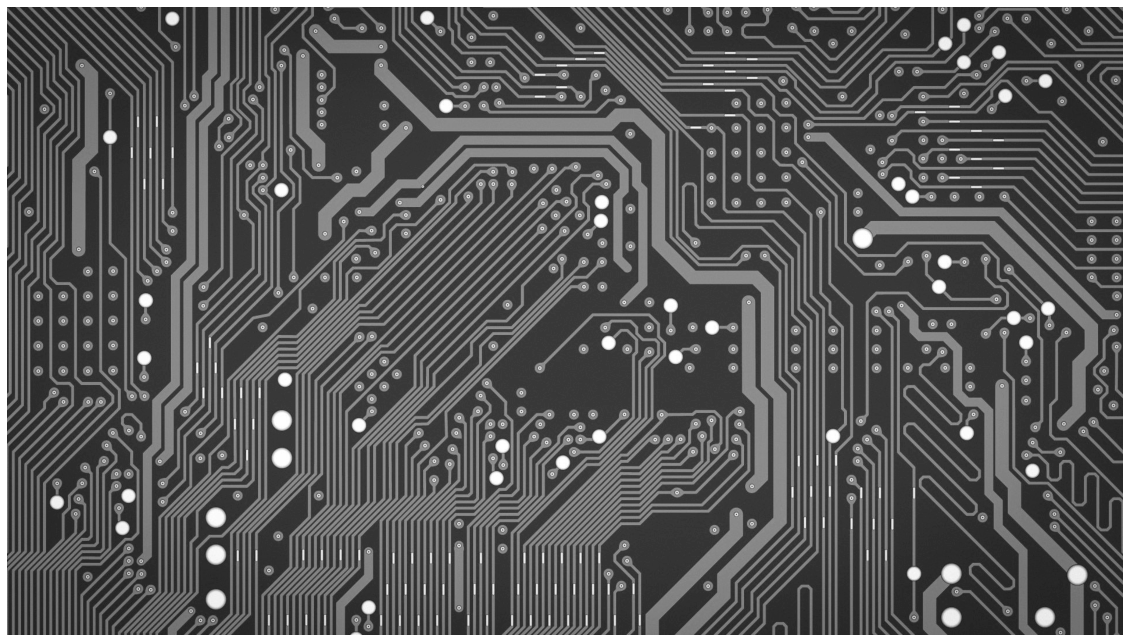

In [4]:

#下載測試影像
url = 'https://evatronix.com/images/en/offer/printed-circuits-board/Evatronix_Printed_Circuits_Board_01_1920x1080.jpg'
testimage = tf.keras.utils.get_file('pcb.jpg', url)  #記得改網址的話 檔名也要改掉

#讀入測試影像
inputs = cv2.imread(testimage)

#轉成灰階影像
inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2GRAY)  #轉成灰階

#顯示測試影像
plt.figure(figsize=(20, 15))
plt.imshow(inputs, cmap='gray')
plt.axis(False)
plt.show()

True

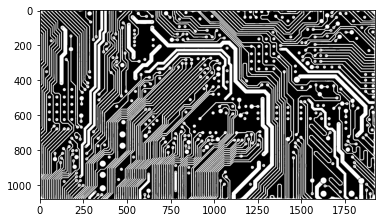

In [5]:

#轉換影像表示方式成四軸張量(sample,height,width,channel)，以便使用卷積運算。
inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
inputs = inputs[tf.newaxis, :, :, tf.newaxis]  #擴增兩個維度

#使用卷積運算製作AdatpiveThresholding
#neighbor_size=61, C=-8
#用61*61的average filter
#AdaptiveThreshold(61,-8)是叫constructor 建構一個物件
#AdaptiveThreshold(61,-8)(inputs)是叫AdaptiveThreshold(61,-8)的call函數
binary = AdaptiveThreshold(61, -8)(inputs)
plt.imshow(tf.squeeze(binary).numpy() * 255, cmap='gray')  #把大於零的部分會被設為255，小於零的部分會被設為0

#存下AdaptiveThresholding結果
#binary這張圖現去掉大小為1的維度，再把大於零的部分會被設為255，小於零的部分會被設為0
outputs = tf.where(tf.squeeze(binary) > 0, tf.constant([[255]], dtype=tf.uint8), tf.constant([[0]], dtype=tf.uint8))
cv2.imwrite('pcb_threshold.png', outputs.numpy())  #存下結果


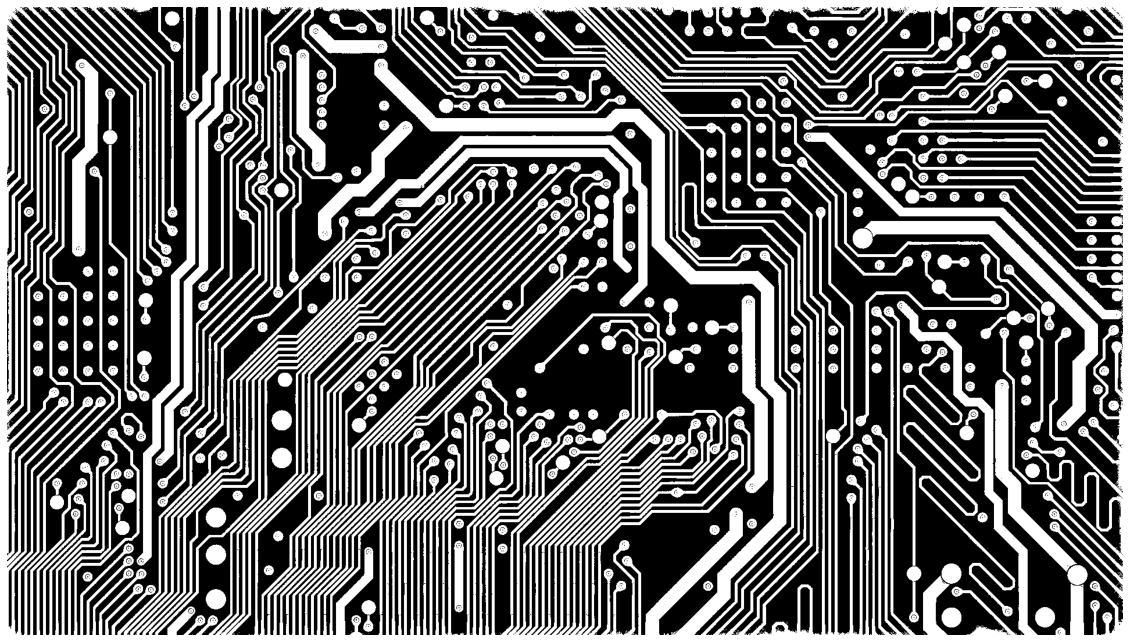

In [6]:
#顯示AdaptiveThresholding結果
plt.figure(figsize=(20, 15))
plt.imshow(tf.squeeze(binary).numpy() * 255, cmap='gray')  #把大於零的部分會被設為255，小於零的部分會被設為0
plt.axis(False)
plt.show()

nine_count_1: 143057
nine_count_2: 141056
nine_count_1: 131925
nine_count_2: 61662
nine_count_1: 22222
nine_count_2: 17096
nine_count_1: 14569
nine_count_2: 13242
nine_count_1: 12889
nine_count_2: 12301
nine_count_1: 10122
nine_count_2: 9535
nine_count_1: 9224
nine_count_2: 8843
nine_count_1: 6318
nine_count_2: 4493
nine_count_1: 3170
nine_count_2: 2892
nine_count_1: 2757
nine_count_2: 2638
nine_count_1: 2505
nine_count_2: 1679
nine_count_1: 74
nine_count_2: 29
nine_count_1: 1
nine_count_2: 1
nine_count_1: 1
nine_count_2: 1
nine_count_1: 1
nine_count_2: 1
nine_count_1: 1
nine_count_2: 1
nine_count_1: 1
nine_count_2: 1
nine_count_1: 1
nine_count_2: 1
nine_count_1: 1


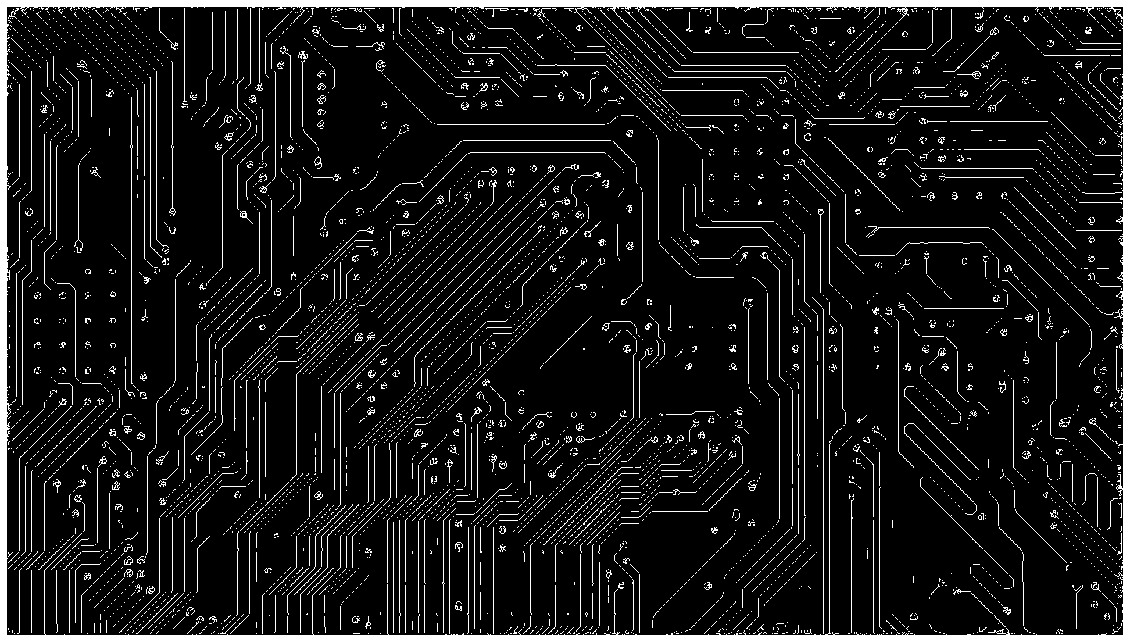

In [7]:

#使用卷積運算製作Thinning (改成-1代表0,1代表1會比較好算)
binary = binary * 2 - 1  #把前景的部分設為1，背景的部分設為-1
#用這個方式 只要區域和kernel一模一樣 就會得到9

#Thinning()(binary) 建立一個物件 直接呼叫call函數
outputs = tf.where(tf.squeeze(Thinning()(binary)) > 0, tf.constant([[255]], dtype=tf.uint8),
                   tf.constant([[0]], dtype=tf.uint8))
outputs = tf.squeeze(outputs)

#存下細線化結果
cv2.imwrite('pcb_thinning.png', outputs.numpy())

#注意由於螢幕解析度，同學在螢幕上看到的細線化結果可能不是真正結果，此時必須看存下來的結果影像。
plt.figure(figsize=(20, 15))
plt.imshow(outputs.numpy(), cmap='gray', interpolation='none')  #不要內插
plt.axis(False)
plt.show()

In [8]:
plt.imsave()

TypeError: imsave() missing 2 required positional arguments: 'fname' and 'arr'